# Comparing to Point Estimates
---
*A case study comparing optimal design analysis to point estimates for tuning curves*

For more background, see the notebook [**Nonparametric Analysis**](../theory/nonparametric-analysis.ipynb) or our paper: [**Show Your Work with Confidence: Confidence Bands for Tuning Curves**](https://arxiv.org/abs/2311.09480).

In [1]:
# imports

import csv
import io
import urllib
import warnings

from matplotlib import pyplot as plt
import numpy as np
from scipy import special, stats

from opda import nonparametric, utils
import opda.random

# constants

styles = {
    "lstm": [
        {"color": "#FFB000", "linestyle": "--"},
        {"color": "#FE6100", "linestyle":  ":"},
    ],
    "mlp": [
        {"color": "#648FFF", "linestyle":  "-"},
        {"color": "#785EF0", "linestyle": "-."},
    ],
}


# Configure environment.

generator = np.random.RandomState(0)
opda.random.set_seed(generator)

warnings.filterwarnings("ignore")


# Configure Matplotlib.

plt.style.use("experiments.default")

## Showing Your Work Doesn't Always Work

Tuning curves capture how performance improves with hyperparameter tuning effort. These curves provide a strong basis for model comparisons; however, estimating them requires training a model many times, which can be expensive.

To reduce this computational burden, [Dodge et al. (2019)](https://aclanthology.org/D19-1224/) introduced an estimator for tuning curves based on [V-statistics](https://en.wikipedia.org/wiki/V-statistic):

$$\hat{\tau}_e(k) = \sum_{i=1}^n Y_{(i)}\left[\left(\frac{i}{n}\right)^k - \left(\frac{i-1}{n}\right)^k\right]$$

Furthermore, they suggested using the bootstrap to create confidence bands; however, [Tang et al. (2020)](https://aclanthology.org/2020.acl-main.246/) showed that the V-statistic estimator can be biased, the bias can promote incorrect decisions, and the bootstrapped confidence bands have poor coverage properties.

To address the bias, they introduced an unbiased estimator based on [U-statistics](https://en.wikipedia.org/wiki/U-statistic):

$$\hat{\tau}_e(k) = \sum_{i=1}^n Y_{(i)}\left[\frac{\binom{i}{k}}{\binom{n}{k}} - \frac{\binom{i-1}{k}}{\binom{n}{k}}\right]$$

Still, they did not provide a method for constructing well-calibrated confidence bands for tuning curves. Later, [Dodge et al. (2021)](https://arxiv.org/abs/2110.00613) gave a more in-depth comparison between the two estimators finding that while they often disagree, neither one is universally preferred over the other.

Thus, different point estimates lead us to different conclusions when making model comparisons. Moreover, bootstrapping point estimates fails to provide us with well-calibrated confidence bands for the tuning curve. Optimal Design Analysis (OPDA) resolves these issues by constructing well-calibrated confidence bands for the tuning curve that let us identify when the data is sufficient to conclude one model is better than another, and when we simply require more data. In this notebook, we reproduce and expand on some of the results from [Tang et al. (2020)](https://aclanthology.org/2020.acl-main.246/), and use them to demonstrate the efficacy of OPDA.

In [2]:
# Download the data.

with io.TextIOWrapper(urllib.request.urlopen(
    "https://raw.githubusercontent.com/castorini/meanmax/master/data/hedwig.tsv",
)) as f_in:
    reader = csv.DictReader(
        f_in,
        fieldnames=None,
        dialect="unix",
        delimiter="\t",
    )
    ys_lstm_all = []
    ys_mlp_all = []
    for row in reader:
        if row["model_name"] == "reg_lstm":
            ys_lstm_all.append(float(row["f1"]))
        elif row["model_name"] == "mlp":
            ys_mlp_all.append(float(row["f1"]))
        else:
            raise ValueError(
                f'Unrecognized model_name: {row["model_name"]}.',
            )

ys_lstm_all = np.array(ys_lstm_all)
ys_mlp_all = np.array(ys_mlp_all)

## Resolving Disagreements Among Point Estimates

When the U-statistic and V-statistic estimates of the tuning curve substantially disagree, it's due to lack of sufficient data or, alternatively, too much sample variation. [Tang et al. (2020)](https://aclanthology.org/2020.acl-main.246/) offers one such example. In particular, they train MLP and LSTM neural network models from scratch on the Reuters text classification dataset [(Apté et al., 1994)](https://dl.acm.org/doi/abs/10.1145/183422.183423) (see their paper for experimental details). Here, we subsample 25 search iterations for each model, which produces the following tuning curves:

In [3]:
# experimental settings

n = 25
ns = np.arange(1, n+1)

confidence = 0.50

seeds = [0, 1]

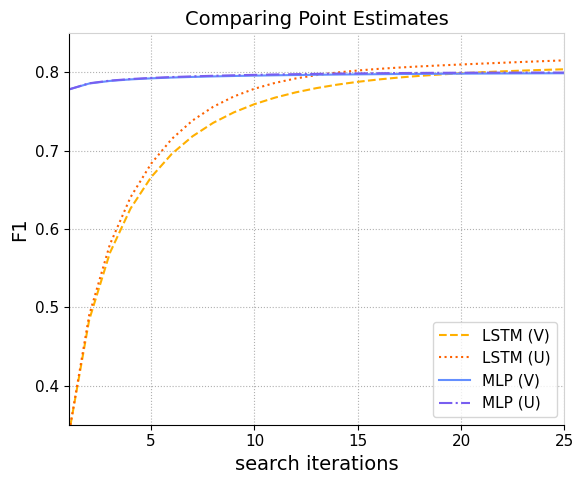

In [4]:
# Subsample the data.
random = np.random.Generator(np.random.PCG64(seeds[0]))

ys_lstm = random.choice(ys_lstm_all, size=n, replace=False)
ys_mlp = random.choice(ys_mlp_all, size=n, replace=False)

# Construct the point estimates.
lstm_point_cdf = nonparametric.EmpiricalDistribution(ys_lstm, a=0., b=1.)
mlp_point_cdf = nonparametric.EmpiricalDistribution(ys_mlp, a=0., b=1.)

# Plot the point estimates for the tuning curves.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(ns, lstm_point_cdf.v_tuning_curve(ns), label="LSTM (V)", **styles["lstm"][0])
ax.plot(ns, lstm_point_cdf.u_tuning_curve(ns), label="LSTM (U)", **styles["lstm"][1])
ax.plot(ns, mlp_point_cdf.v_tuning_curve(ns), label="MLP (V)", **styles["mlp"][0])
ax.plot(ns, mlp_point_cdf.u_tuning_curve(ns), label="MLP (U)", **styles["mlp"][1])

# Format the plot.
ax.set_xlim(1, n)
ax.set_ylim(0.35, 0.85)
ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")
ax.legend(loc="lower right")

ax.set_xlabel("search iterations")
ax.set_ylabel("F1")

ax.set_title("Comparing Point Estimates")

fig.tight_layout()

plt.show()

The different point estimates result in different conclusions about how many search iterations are necessary for the LSTM to outperform the MLP. The V-statistic suggests about 20 search iterations are required, while the U-statistic suggests only 12-13 are necessary.

Since the point estimates lead to different conclusions, a researcher or practitioner might end up making an arbitrary choice that depends solely on which estimator they used. To avoid this issue, one might try both; however, what's even worse is that *both* estimators fail to reflect the high degree of sample variation that's present due to lack of sufficient data. To see this, consider re-running the experiment with a different random seed:

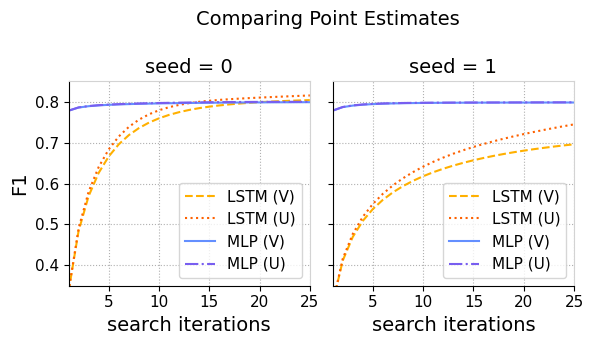

In [5]:
# Plot the point estimates using two different random seeds.
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)
for i, seed in enumerate(seeds):
    # Subsample the data.
    random = np.random.Generator(np.random.PCG64(seed))

    ys_lstm = random.choice(ys_lstm_all, size=n, replace=False)
    ys_mlp = random.choice(ys_mlp_all, size=n, replace=False)

    # Construct the point estimates.
    lstm_point_cdf = nonparametric.EmpiricalDistribution(ys_lstm, a=0., b=1.)
    mlp_point_cdf = nonparametric.EmpiricalDistribution(ys_mlp, a=0., b=1.)

    # Plot the model comparison using point estimates.
    axes[i].plot(
        ns,
        lstm_point_cdf.v_tuning_curve(ns),
        label="LSTM (V)",
        **styles["lstm"][0],
    )
    axes[i].plot(
        ns,
        lstm_point_cdf.u_tuning_curve(ns),
        label="LSTM (U)",
        **styles["lstm"][1],
    )
    axes[i].plot(
        ns,
        mlp_point_cdf.v_tuning_curve(ns),
        label="MLP (V)",
        **styles["mlp"][0],
    )
    axes[i].plot(
        ns,
        mlp_point_cdf.u_tuning_curve(ns),
        label="MLP (U)",
        **styles["mlp"][1],
    )

# Format the plot.
for i, seed in enumerate(seeds):
    axes[i].set_xlim(1, n)
    axes[i].set_ylim(0.35, 0.85)
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")
    axes[i].legend(loc="lower right")
    axes[i].set_xlabel("search iterations")
    axes[i].set_title(f"seed = {seed}")

axes[0].set_ylabel("F1")

fig.suptitle(
    "Comparing Point Estimates",
    x=0.56,
)

fig.tight_layout()

plt.show()

In this case, the sample impacts our conclusions much more than the choice of estimator. Moreover, because each hyperparameter search iteration is computationally expensive, it's unlikely that we'd generate extra samples, and thus this variation is much more likely to go unnoticed.

The confidence bands from OPDA resolve this issue. Because they have exact coverage, they inform researchers and practitioners when the sample variation is large. Thus, in the cases where point estimates disagree, the confidence bands will show that we need more data. Moreover, even when the estimates *do* agree but the sample variation is unacceptably large, the confidence bands will still alert us. The plot below demonstrates this comparison:

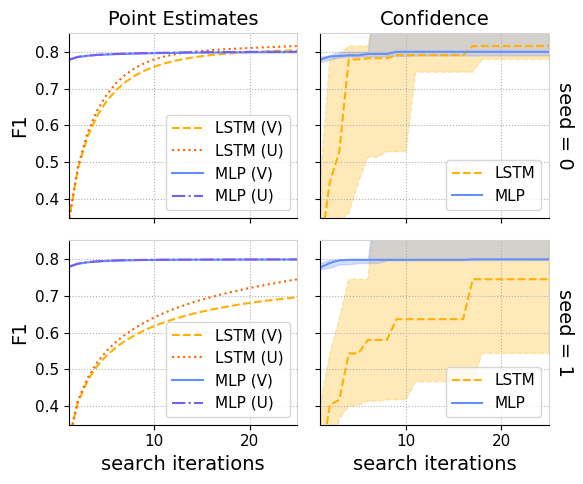

In [6]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 5),
)
for i, seed in enumerate(seeds):
    random = np.random.Generator(np.random.PCG64(seed))

    ys_lstm = random.choice(ys_lstm_all, size=n, replace=False)
    ys_mlp = random.choice(ys_mlp_all, size=n, replace=False)

    lstm_lower_cdf, lstm_point_cdf, lstm_upper_cdf =\
        nonparametric.EmpiricalDistribution.confidence_bands(
            ys_lstm, confidence, a=0., b=1., method="ld_highest_density",
        )
    mlp_lower_cdf, mlp_point_cdf, mlp_upper_cdf =\
        nonparametric.EmpiricalDistribution.confidence_bands(
            ys_mlp, confidence, a=0., b=1., method="ld_highest_density",
        )

    # Plot the model comparison using point estimates.
    axes[i, 0].plot(
        ns,
        lstm_point_cdf.v_tuning_curve(ns),
        label="LSTM (V)",
        **styles["lstm"][0],
    )
    axes[i, 0].plot(
        ns,
        lstm_point_cdf.u_tuning_curve(ns),
        label="LSTM (U)",
        **styles["lstm"][1],
    )
    axes[i, 0].plot(
        ns,
        mlp_point_cdf.v_tuning_curve(ns),
        label="MLP (V)",
        **styles["mlp"][0],
    )
    axes[i, 0].plot(
        ns,
        mlp_point_cdf.u_tuning_curve(ns),
        label="MLP (U)",
        **styles["mlp"][1],
    )

    # Plot the model comparison using confidence bands.
    axes[i, 1].plot(
        ns,
        lstm_point_cdf.quantile_tuning_curve(ns),
        label="LSTM",
        **styles["lstm"][0],
    )
    axes[i, 1].fill_between(
        ns,
        lstm_upper_cdf.quantile_tuning_curve(ns),
        lstm_lower_cdf.quantile_tuning_curve(ns),
        alpha=0.275,
        **styles["lstm"][0],
    )
    axes[i, 1].plot(
        ns,
        mlp_point_cdf.quantile_tuning_curve(ns),
        label="MLP",
        **styles["mlp"][0],
    )
    axes[i, 1].fill_between(
        ns,
        mlp_upper_cdf.quantile_tuning_curve(ns),
        mlp_lower_cdf.quantile_tuning_curve(ns),
        alpha=0.275,
        **styles["mlp"][0],
    )

# Format the plot.
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i, j].set_xlim(1, n)
        axes[i, j].set_ylim(0.35, 0.85)
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")
        axes[i, j].legend(loc="lower right")

for j in range(axes.shape[1]):
    axes[1, j].set_xlabel("search iterations")

for i, seed in enumerate(seeds):
    axes[i, 0].set_ylabel("F1")
    axes[i, 1].yaxis.set_label_position("right")
    axes[i, 1].set_ylabel(f"seed = {seed}", labelpad=18, rotation=270)

axes[0, 0].set_title("Point Estimates")
axes[0, 1].set_title("Confidence")

fig.tight_layout()

plt.show()

We see that using 50% confidence bands for the median tuning curve reveals the tremendous amount of sample variation present in the estimates. Thus, while the LSTM is likely better than the MLP at some level of hyperparameter tuning, it's unclear just how much tuning is necessary to get there.

## Bootstrap Confidence Band Coverage Issues

The nonparametric confidence bands from OPDA are exact, distribution-free, and hold simultaneously for the entire tuning curve; thus, they provide most of properties one would hope for from such a confidence band. Still, implementing the OPDA confidence bands takes a bit more effort than generic, approximate approaches such as the bootstrap. If one doesn't have access to software implementing OPDA (or before OPDA was developed), one might hope that bootstrapping a point estimate would provide reasonable confidence bands.

Unfortunately, [Tang et al. (2020)](https://aclanthology.org/2020.acl-main.246/) demonstrated that such bootstrap confidence bands fail to provide meaningful coverage. Again, using the data from [Tang et al. (2020)](https://aclanthology.org/2020.acl-main.246/) we follow a similar methodology and show that the pointwise coverage of the bootstrap confidence bands for the tuning curve rapidly decreases at higher value points, $n$, along the curve.

### Realistically Simulating Random Search

First, we must construct a good simulation of random hyperparameter search for the MLP and LSTM text classifiers. That way, our experiments are realistic because the distributions closely approximate those from actual models; while at the same time, we know the ground truth from how we constructed the simulation and thus can assess the confidence bands' coverage.

Like [Tang et al. (2020)](https://aclanthology.org/2020.acl-main.246/), we form a [kernel density estimate (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation) for the distribution of performance from each iteration of random search. It's important to use KDE rather than resampling because confidence bands' coverage properties can be affected by whether the underlying distribution is continuous (KDE) or discrete (resampled). In general, we assume that all distributions are continuous.

#### Boundary Correction for KDE

Because the model accuracy is bounded between 0 and 1, we should apply a boundary correction to the KDE estimate. Reflection of the kernel back from the boundary provides a simple and effective boundary correction (see [Jones et al. (1993)](https://doi.org/10.1007/BF00147776) for more information). Below, you can see a comparison between an uncorrected and a corrected KDE estimate for the uniform distribution.

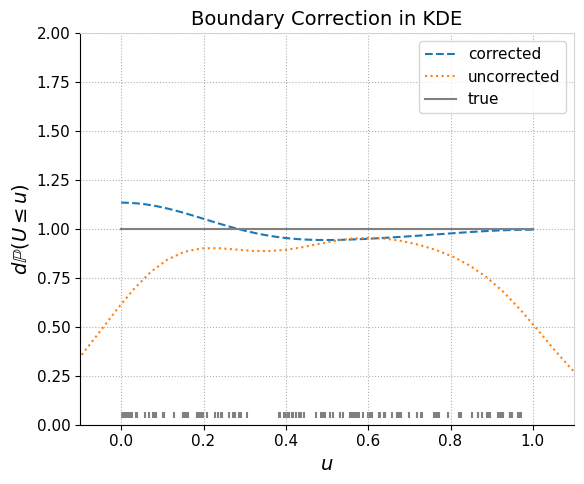

In [7]:
# Sample the data.
us = generator.uniform(0, 1, size=(128))

# Construct the KDEs.
kde_uncorrected = stats.gaussian_kde(
    us,
    bw_method=0.5,
)
kde_corrected = stats.gaussian_kde(
    # Reflect the kernel's mass by reflecting the data points.
    # For all practical purposes, the kernel reflects off each boundary
    # effectively once since the bandwidth is small relative to the
    # length of the support. Thus, we don't need to use additional
    # copies of the data for higher order reflections.
    np.concatenate([-us, us, 2-us]),
    bw_method=0.25,
)

# Plot the KDEs.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.scatter(
    us,
    5e-2 * np.ones_like(us),
    marker="|",
    color="grey",
    s=25,
)
ax.plot(
    np.linspace(0, 1),
    # Multiply by 3 to account for the data's triplication.
    3 * kde_corrected.pdf(np.linspace(0, 1)),
    color="tab:blue",
    linestyle="--",
    label="corrected",
)
ax.plot(
    np.linspace(-0.5, 1.5),
    kde_uncorrected.pdf(np.linspace(-0.5, 1.5)),
    color="tab:orange",
    linestyle=":",
    label="uncorrected",
)
ax.plot(
    np.linspace(0, 1),
    np.ones_like(np.linspace(0, 1)),
    color="grey",
    linestyle="-",
    label="true",
)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(0, 2)
ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")
ax.legend(loc="upper right")
ax.set_xlabel("$u$")
ax.set_ylabel(r"$d\mathbb{P}(U \leq u)$")
ax.set_title("Boundary Correction in KDE")

fig.tight_layout()

plt.show()

In the plot, we see that the uncorrected KDE lets probability mass spill over the boundary. If we truncate and renormalized this distribution, this spillage still leads to a negative bias near the boundary and prevents the KDE from being a consistent estimator of the density. In contrast, reflection removes this bias for the uniform distribution and reduces it in the general case, making the KDE consistent even at the boundary.

#### Determining the KDE Bandwidth

The most important hyperparameter for KDE is the bandwidth. For our purpose, we want a small bandwidth so that the simulation behaves much like resampling; however, we also want a large enough bandwidth to remove the discontinuity effects and approximate the underlying continuous distribution. Cross-validation based on likelihood encourages too large of a bandwidth in order to cover unseen data points with high probability density. Instead, we want a bandwidth that preserves the shape of the CDF so we'll select it visually by inspecting PDF and CDF plots.

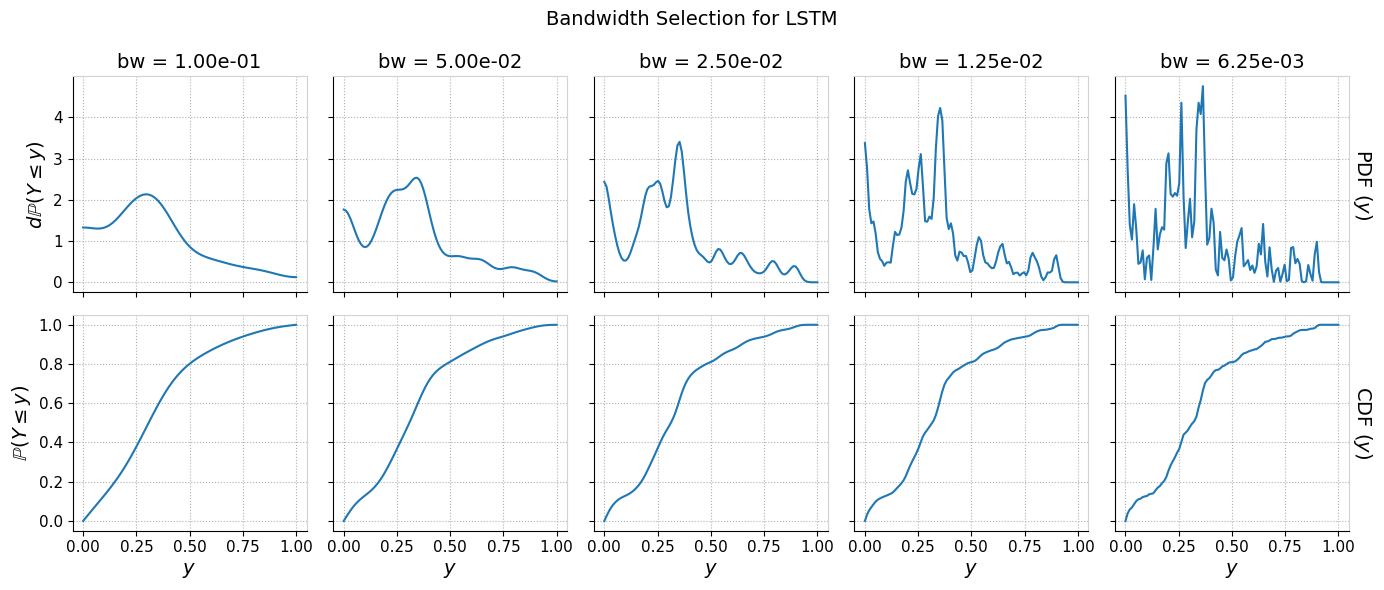

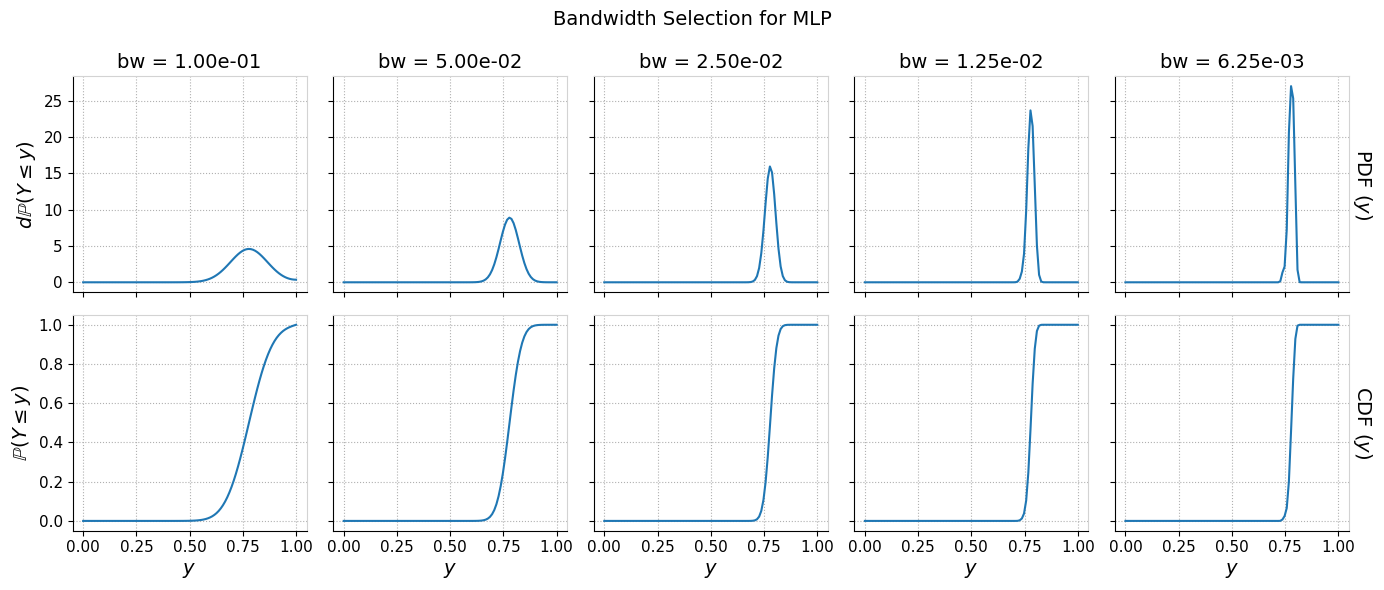

In [8]:
y_min = 0.
y_max = 1.

grid = np.linspace(y_min, y_max, num=100)

simulations = [("lstm", ys_lstm_all), ("mlp", ys_mlp_all)]
bws = [0.1, 0.05, 0.025, 0.0125, 0.00625]
for name, ys in simulations:
    fig, axes = plt.subplots(
        nrows=2,
        ncols=5,
        sharex=True,
        sharey="row",
        figsize=(14, 6),
    )
    for j, bw in enumerate(bws):
        kde = stats.gaussian_kde(
            # Reflect the kernel's mass by reflecting the data points.
            # For all practical purposes, the kernel reflects off each boundary
            # effectively once since the bandwidth is small relative to the
            # length of the support. Thus, we don't need to use additional
            # copies of the data for higher order reflections.
            np.concatenate([-ys, ys, 2-ys]),
            bw_method=bw,
        )

        axes[0, j].plot(
            grid,
            # Multiply by 3 to account for the data's triplication.
            3 * kde.pdf(grid),
        )
        axes[1, j].plot(
            grid,
            # Multiply by 3 to account for the data's triplication.
            [3 * kde.integrate_box_1d(y_min, y) for y in grid],
        )

    # Format the plots.
    for j, bw in enumerate(bws):
        axes[1, j].set_xlabel("$y$")
        axes[0, j].set_title(f"bw = {bw:.2e}")

    for i, kind in enumerate(["PDF ($y$)", "CDF ($y$)"]):
        axes[i, -1].yaxis.set_label_position("right")
        axes[i, -1].set_ylabel(kind, labelpad=18, rotation=270)

    axes[0, 0].set_ylabel(r"$d\mathbb{P}(Y \leq y)$")
    axes[1, 0].set_ylabel(r"$\mathbb{P}(Y \leq y)$")

    for i in range(2):
        for j in range(len(bws)):
            axes[i, j].spines["right"].set_color("lightgrey")
            axes[i, j].spines["top"].set_color("lightgrey")

    fig.suptitle(f"Bandwidth Selection for {name.upper()}")

    fig.tight_layout()

    plt.show()

Based on the above plots, bandwidths of 5e-2 and 1.25e-2 seem reasonable for the LSTM and MLP simulations, respectively.

In [9]:
# Set bandwidths for LSTM and MLP simulations.
bw_lstm = 5e-2
bw_mlp = 1.25e-2

# Create functions to simulate random search iterations.
def simulate_random_search(n_samples, model):
    if model == "lstm":
        ys = ys_lstm_all
        bw = bw_lstm
    elif model == "mlp":
        ys = ys_mlp_all
        bw = bw_mlp
    else:
        raise ValueError(
            f'model must be either "lstm" or "mlp", not {model}.',
        )

    # Construct the KDE using reflection for boundary correction.
    kde = stats.gaussian_kde(
        np.concatenate([-ys, ys, 2-ys]),
        bw_method=bw,
    )

    # Use rejection sampling to sample from the KDE renormalized
    # within the support's bounds.
    ys = kde.resample(50 + 10 * n_samples, seed=generator).squeeze()
    ys = ys[(y_min <= ys) & (ys <= y_max)][:n_samples]
    if len(ys) < n_samples:
        raise RuntimeError(
            "Rejection sampling failed to produce enough samples.",
        )

    return ys

### Computing Pointwise Coverage for Bootstrap Confidence Bands

Now that we have realistic simulations of random search to serve as our ground truth, we can assess the bootstrap confidence bands' coverage. To do this, we'll simulate random search for the models, compute bootstrap confidence bands based on the estimators, and then check whether the true tuning curve is covered by the confidence bands at each point. Repeating this process many times, we can estimate the true coverage and construct Clopper-Pearson binomial confidence intervals for it.

We use the experimental settings below for the bootstrap confidence bands' confidence level, number of bootstrap iterations, and so on.

In [10]:
# experimental settings

bootstrap_confidence = 0.95

n_bootstrap = 4_096

n = 50
ns = np.arange(1, n + 1)

n_trials = 4_096
coverage_confidence = 0.95

In [11]:
# NOTE: This cell might take a number of minutes to run.

# Estimate coverage for the bootstrap confidence bands in simulation.
estimator_to_model_to_covered = {
    "u-statistic": {"lstm": [], "mlp": []},
    "v-statistic": {"lstm": [], "mlp": []},
}
for estimator, model_to_covered in estimator_to_model_to_covered.items():
    for model, covered in model_to_covered.items():
        # Compute the true tuning curve via sampling.
        tuning_curve = np.mean(
            np.maximum.accumulate(
                simulate_random_search(
                    16 * n_bootstrap * n, model,
                ).reshape(16 * n_bootstrap, n),
                axis=1,
            ),
            axis=0,
        )
        for _ in range(n_trials):
            # Sample ys from the simulation.
            ys_simulation = simulate_random_search(n, model)

            # Form the bootstrap confidence bands by resampling.
            ys_resampled = generator.choice(
                ys_simulation, size=(n_bootstrap, n), replace=True,
            )
            ys_resampled.sort(kind="quicksort", axis=-1)

            if estimator == "u-statistic":
                lo, hi = np.quantile(
                    np.sum(
                        (
                            (
                                special.comb(ns, ns[..., None])
                                - special.comb(ns - 1, ns[..., None])
                            ) / special.comb(n, ns[..., None])
                        )[None, ...]
                        * ys_resampled[:, None, :],
                        axis=2,
                    ),
                    q=[
                        0.5 - bootstrap_confidence/2,
                        0.5 + bootstrap_confidence/2,
                    ],
                    axis=0,
                )
            elif estimator == "v-statistic":
                lo, hi = np.quantile(
                    np.sum(
                        (
                            (ns / n)**ns[..., None]
                            - ((ns - 1) / n)**ns[..., None]
                        )[None, ...]
                        * ys_resampled[:, None, :],
                        axis=2,
                    ),
                    q=[
                        0.5 - bootstrap_confidence/2,
                        0.5 + bootstrap_confidence/2,
                    ],
                    axis=0,
                )
            else:
                raise ValueError(
                    f'estimator must be "u-statistic" or "v-statistic",'
                    f' not {estimator}.',
                )

            # Check if the true tuning curve is covered.
            covered.append(
                (lo <= tuning_curve) & (tuning_curve <= hi),
            )

Having run the simulation, we can now plot the true coverage at each point of the tuning curve.

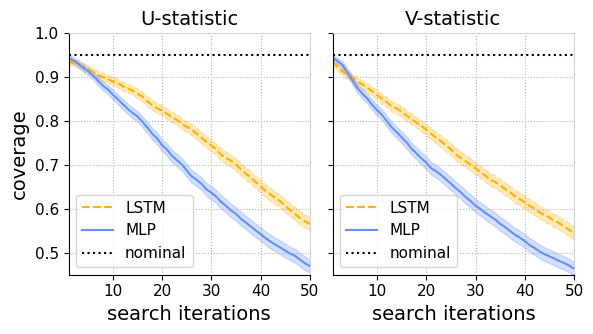

In [12]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)
# Plot the pointwise coverage as a function of the search iteration.
for i, (_, model_to_covered) in enumerate(estimator_to_model_to_covered.items()):
    for model, covered in model_to_covered.items():
        axes[i].plot(
            ns,
            np.mean(covered, axis=0),
            label=model.upper(),
            **styles[model][0],
        )
        axes[i].fill_between(
            ns,
            *utils.binomial_confidence_interval(
                n_successes=np.sum(covered, axis=0),
                n_total=n_trials,
                confidence=coverage_confidence,
            ),
            alpha=0.275,
            **styles[model][0],
        )
    axes[i].axhline(
        bootstrap_confidence,
        linestyle=":",
        color="k",
        label="nominal",
    )

# Format the plot.
for i, estimator in enumerate(estimator_to_model_to_covered.keys()):
    axes[i].set_xlim(1, n)
    axes[i].set_ylim(0.45, 1.0)
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")
    axes[i].legend(loc="lower left")

    axes[i].set_xlabel("search iterations")
    axes[i].set_title(estimator.capitalize())

axes[0].set_ylabel("coverage")

fig.tight_layout()

plt.show()

We see that the true coverage drops off precipitously as we move right along the tuning curve. Thus, while the bootstrap confidence bands have close to the nominal coverage for the first few points along the tuning curve, the pointwise coverage quickly drops, making the bootstrap confidence bands misleading and difficult to interpret.

In contrast, the nonparametric confidence bands from OPDA have exact coverage under distribution-free assumptions&mdash;the only requirement is that the performance distribution be continuous (as opposed to discrete). The nonparametric OPDA confidence bands are not directly comparable to the bootstrap confidence bands because the OPDA bands provide a *simultaneous* coverage guarantee and bound the *median* tuning curve, while the bootstrap bands attempt to provide *pointwise* coverage for the *mean*; however, in situations where one might want to use the bootstrap bands, the OPDA bands are probably a better choice due to their stronger guarantees and accurate and exact coverage.